<a href="https://colab.research.google.com/github/gremlin97/Turion/blob/main/segnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Extracting the space parts segmentation dataset
!unzip -q /content/drive/MyDrive/Final_dataset.zip

replace Final_dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Final_dataset/all_bbox.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# removing extra/redundant file
!rm -rf /content/Final_dataset/images/train/.DS_Store

In [ ]:
# Importing the required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

In [ ]:
dir = '/content/Final_dataset'

# Transforms to be applied on the training/val dataset
transform = transforms.Compose([
                           transforms.Resize((256,256)),
                           transforms.ToTensor()# Convert to Tensor,
                          #  transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                          #  transforms.Normalize((0.2212,), (0.2413,))
                           ])

In [ ]:
# Checking length of the training set and the corresponding masks
len(list(os.listdir(dir + '/images/train'))), len(list(os.listdir(dir + '/mask/train')))

(2517, 2517)

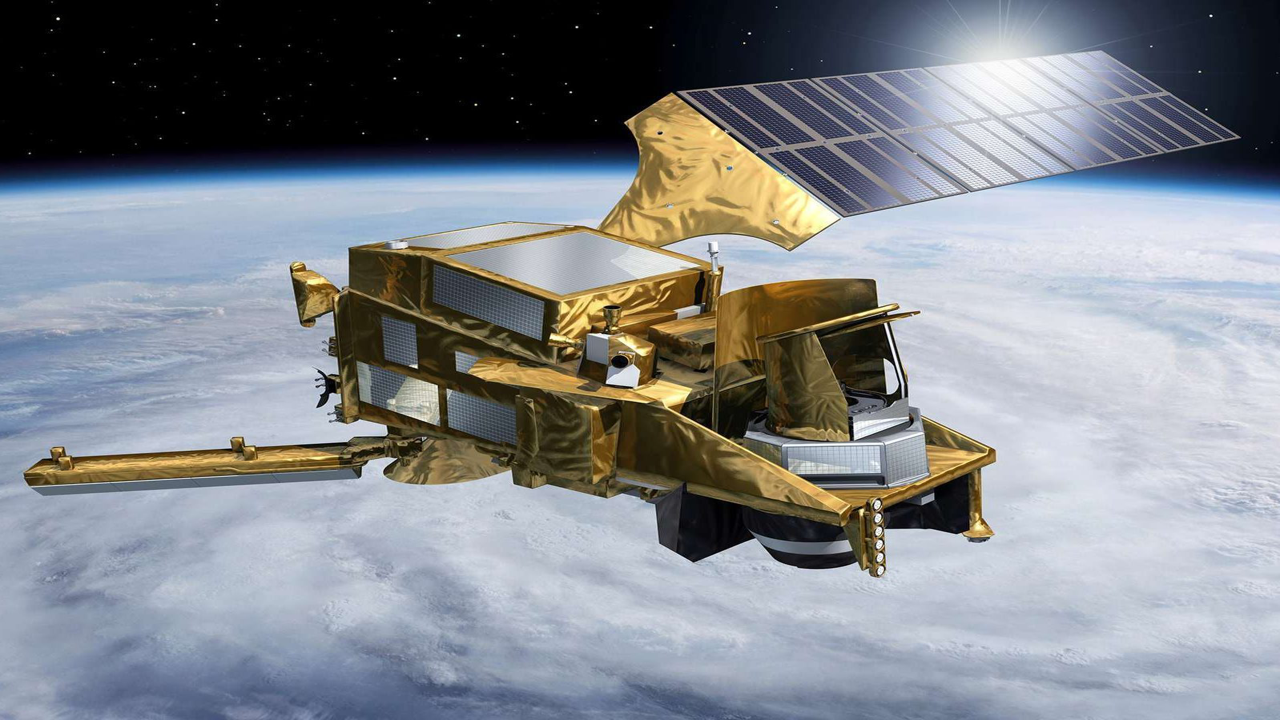

In [ ]:
# Sampling an image from the training set
par_img_path = list(os.listdir(dir + '/images/train'))[0]
img_path = dir + '/images/train'+ '/' +par_img_path
img = Image.open(img_path)
img.show()

### PyTorch Custom Dataset : SatelliteSeg(Dataset)

__init__(self, dir, transform, train=True)

Initializes the SatelliteSeg dataset class with the given arguments:

    transform: A function/transform that takes in a PIL image and returns a transformed version.
    train: A boolean value indicating whether to load the training dataset (True) or the validation dataset (False). Default is True.

__len__(self)

Returns the length of the dataset. In this case, it returns the number of images in the dataset directory.

__getitem__(self, idx)

Returns the image and mask tensors for a given index.

    idx: The index of the item to be retrieved.

It does the following:

    Reads in the image and mask from their respective folders using the given index.

    Converts the image and mask to RGB format.

    Resizes the mask to (256, 256) using nearest neighbor interpolation.

    Converts the mask to a tensor, where the class labels are mapped as follows:
        1: Red class
        2: Green class
        3: Blue class

    Applies the transform function to the image (if transform is not None).

    Returns the transformed image and the corresponding mask as tensors.

In [ ]:
class SatelliteSeg(Dataset):
  def __init__(self, dir, transform, train=True):
    self.dir = dir
    self.transform = transform

    if train:
      self.data_dir = dir + '/images/train'
      self.mask_dir = dir + '/mask/train'
    else:
      self.data_dir = dir + '/images/val'
      self.mask_dir = dir + '/mask/val'

  def __len__(self):
    self.img_path = list(os.listdir(self.data_dir))[:403]
    return len(self.img_path)

  def __getitem__(self, idx):

    img = self.data_dir + '/' + f'img_resize_{idx}.png'
    mask = self.mask_dir + '/' + f'img_resize_{idx}_mask.png'

    img = Image.open(img).convert('RGB')
    mask = Image.open(mask).convert('RGB')

    mask = mask.resize((256,256), resample=Image.NEAREST)

    mask_array = np.array(mask)
    label = torch.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=torch.uint8)
    label[(mask_array == np.array([255, 0, 0])).all(axis=2)] = 1  # red class
    label[(mask_array == np.array([0, 255, 0])).all(axis=2)] = 2  # green class
    label[(mask_array == np.array([0, 0, 255])).all(axis=2)] = 3  # blue class

    label = label.type(torch.LongTensor)
  
    if self.transform:
      img = self.transform(img)

    return img, label

train = SatelliteSeg(dir, transform)    

In [ ]:
train_dir = dir + '/images/train'
img_path = list(os.listdir(train_dir))
img_path = img_path[0:402]
len(img_path)

402

In [ ]:
img, mask = next(iter(train))
img.size(), mask.size()

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

In [ ]:
torch.max(mask), type(mask)

(tensor(2), torch.Tensor)

In [ ]:
len(train)

403

In [ ]:
train_loader = DataLoader(train, batch_size=16, drop_last=True)

In [ ]:
# ================= Code to calculate train dataloader mean and std =================#

# mean = 0.
# meansq = 0.
# for i, (data,mask) in enumerate(train_loader):
#     mean = data.mean()
#     meansq = (data**2).mean()

# std = torch.sqrt(meansq - mean**2)
# print("mean: " + str(mean))
# print("std: " + str(std))
# print()

In [ ]:
# for i, (img,mask) in enumerate(train_loader, 0):
#   print(img.size())
#   print(mask.size())

In [ ]:
imgs, masks = next(iter(train_loader))
imgs.size(), masks.size()

(torch.Size([16, 3, 256, 256]), torch.Size([16, 256, 256]))

In [ ]:
class SegNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.prep = nn.Sequential(
        nn.Conv2d(3,64,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64,64,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(64)
    )

    #self.pool = nn.MaxPool2d(2,2, return_indices=True)

    self.enc1 = nn.Sequential(
        nn.Conv2d(64,128,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128,128,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(128)
    ) 

    self.enc2 = nn.Sequential(
        nn.Conv2d(128,256,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.Conv2d(256,256,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(256)
    )

    self.dec1 = nn.Sequential(
        nn.Conv2d(256,256,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.Conv2d(256,256,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(256)
    )  

    self.conv_dec1 = nn.Conv2d(256,128,1,1)

    self.unpool = nn.MaxUnpool2d(2,2)
    self.unpool1 = nn.MaxUnpool2d(2,2)

    self.dec2 = nn.Sequential(
        nn.Conv2d(128,128,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128,128,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(128)
    )  

    self.conv_dec2 = nn.Conv2d(128,64,1,1)

    self.final = nn.Sequential(
        nn.Conv2d(64,64,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64,64,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(64)
    ) 

    self.conv_dec3 = nn.Sequential(
        nn.Conv2d(64,4,1,1),
        nn.BatchNorm2d(4)
    )

  def forward(self, x):
    in_size = x.size()

    x = self.prep(x)
    x, ind_prep = F.max_pool2d(x, 2, 2, return_indices=True)
    prep_size = x.size()
    #print(prep_size)

    x = self.enc1(x)
    x , ind_enc1 = F.max_pool2d(x, 2, 2, return_indices=True)
    enc1_size = x.size()
    #print(enc1_size)

    x = self.enc2(x)
    x, ind_enc2 = F.max_pool2d(x, 2, 2 ,return_indices=True)

    x = self.unpool(x, ind_enc2, output_size=enc1_size)
    x = self.dec1(x)
    #print(x.size())
    x = self.conv_dec1(x)
    #print(x.size())

    x = self.unpool(x, ind_enc1, output_size=prep_size) 
    x = self.dec2(x)
    x = self.conv_dec2(x)
    
    x = self.unpool(x, ind_prep, output_size=in_size) 
    x = self.final(x)
    x = self.conv_dec3(x)
    
    # x = F.softmax(x,dim=1)
    return x

Setting up device, model and doing some sanity checks on the model. Model summary is also displayed.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = SegNet()

In [ ]:
out = model(torch.rand(2,3,32,32))

In [ ]:
from torchsummary import summary
summary(model.to(device),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]          36,928
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,584
             ReLU-11          [-1, 128, 16, 16]               0
      BatchNorm2d-12          [-1, 128, 16, 16]             256
           Conv2d-13            [-1, 256, 8, 8]         295,168
             ReLU-14            [-1, 25

In [ ]:
# Defining hyperparameters
lr = 0.01
num_epochs = 20
batch_size = 16

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Training loop for training the model instantiated above
for epoch in range(num_epochs):
    # set model to training mode
    model.train()

    # initialize loss and accuracy
    epoch_loss = 0.0
    epoch_acc = 0.0

    # loop over training batches
    for images, masks in train_loader:
        # send data to device
        images = images.to(device)
        masks = masks.to(device)

        # zero gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(images)

        # calculate loss
        loss = criterion(outputs, masks)

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()

        # calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == masks).all(dim=1).sum().item()
        accuracy = correct / (batch_size * images.shape[2] * images.shape[3])

        # update epoch loss and accuracy
        epoch_loss += loss.item() * images.shape[0]
        epoch_acc += accuracy * images.shape[0]

    # normalize epoch loss and accuracy
    epoch_loss /= len(train)
    epoch_acc /= len(train)

    # print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    # set model to evaluation mode
    model.eval()

    # initialize validation loss and accuracy
    val_loss = 0.0
    val_acc = 0.0

    # loop over validation batches
    with torch.no_grad():
        for images, masks in train_loader:
            # send data to device
            images = images.to(device)
            masks = masks.to(device)

            # forward pass
            outputs = model(images)

            # calculate loss
            loss = criterion(outputs, masks)

            # calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == masks).all(dim=1).sum().item()
            accuracy = correct / (batch_size * images.shape[2] * images.shape[3])

            # update validation loss and accuracy
            val_loss += loss.item() * images.shape[0]
            val_acc += accuracy * images.shape[0]

    # normalize validation loss and accuracy
    val_loss /= len(train)
    val_acc /= len(train)

Epoch 1/20, Train Loss: 1.1452, Train Acc: 0.0002
Epoch 2/20, Train Loss: 0.5750, Train Acc: 0.0010
Epoch 3/20, Train Loss: 0.4485, Train Acc: 0.0011
Epoch 4/20, Train Loss: 0.4028, Train Acc: 0.0011
Epoch 5/20, Train Loss: 0.3781, Train Acc: 0.0011
Epoch 6/20, Train Loss: 0.3529, Train Acc: 0.0011
Epoch 7/20, Train Loss: 0.3324, Train Acc: 0.0011
Epoch 8/20, Train Loss: 0.3153, Train Acc: 0.0011
Epoch 9/20, Train Loss: 0.3021, Train Acc: 0.0011
Epoch 10/20, Train Loss: 0.2899, Train Acc: 0.0011
Epoch 11/20, Train Loss: 0.2762, Train Acc: 0.0011
Epoch 12/20, Train Loss: 0.2676, Train Acc: 0.0011
Epoch 13/20, Train Loss: 0.2576, Train Acc: 0.0011
Epoch 14/20, Train Loss: 0.2477, Train Acc: 0.0011
Epoch 15/20, Train Loss: 0.2353, Train Acc: 0.0011
Epoch 16/20, Train Loss: 0.2338, Train Acc: 0.0011
Epoch 17/20, Train Loss: 0.2253, Train Acc: 0.0011
Epoch 18/20, Train Loss: 0.2134, Train Acc: 0.0012
Epoch 19/20, Train Loss: 0.2052, Train Acc: 0.0012
Epoch 20/20, Train Loss: 0.1962, Train A

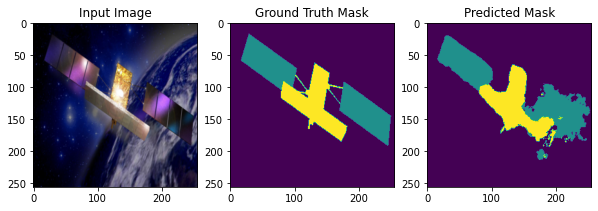

In [ ]:
# Plotting model output results. Model is currently only tested on the training dataset. In the future proper checks will be implemented
import matplotlib.pyplot as plt
import numpy as np

# Load an image and corresponding mask
image, mask = train[4]

image = image.to(device)
mask = mask.to(device)

# Apply the model to the image
output = model(image.unsqueeze(0))

# Get the predicted segmentation labels
predicted_labels = output.argmax(dim=1)

# Convert predicted labels to a numpy array
predicted_labels_np = predicted_labels[0].cpu().numpy()

# Display the input image, ground truth mask, and predicted mask
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

# Plot input image
ax[0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
ax[0].set_title('Input Image')

# Plot ground truth mask
ax[1].imshow(mask.squeeze().cpu().numpy())
ax[1].set_title('Ground Truth Mask')

# Plot predicted mask
ax[2].imshow(predicted_labels_np)
ax[2].set_title('Predicted Mask')

plt.show()